In [16]:
import os
import sys
import math
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
cmap = mcolors.LinearSegmentedColormap.from_list('WhRd',['#e5e5e5', "#fffacd", "red", "darkred"], N=256)  

import networkx as nx
import seaborn as sns

In [315]:
edge_weights_scale_factor = 10
node_size_scale_factor = 35

In [3]:
adata = sc.read_h5ad("../Xenium_all.h5ad")
celltype_color_dict = dict(zip(adata.obs.celltype_plot.cat.categories, adata.uns["celltype_colors"]))

Figure 4D

In [352]:
z_score_df = pd.read_csv("ShamR_zscores_d55_perm.csv", index_col=0)

In [353]:
z_score_df[z_score_df<1]=0

In [355]:
celltype_color_dict = dict(zip(adata.obs['celltype_plot'].cat.categories,adata.uns['celltype_plot_colors']))

In [356]:
shamR = adata[adata.obs["ident"] == "ShamR"].copy()

In [357]:
cell_cnt = pd.DataFrame(shamR.obs["celltype"].value_counts()).reset_index()
cell_cnt.columns = ['CellType', "Count"]

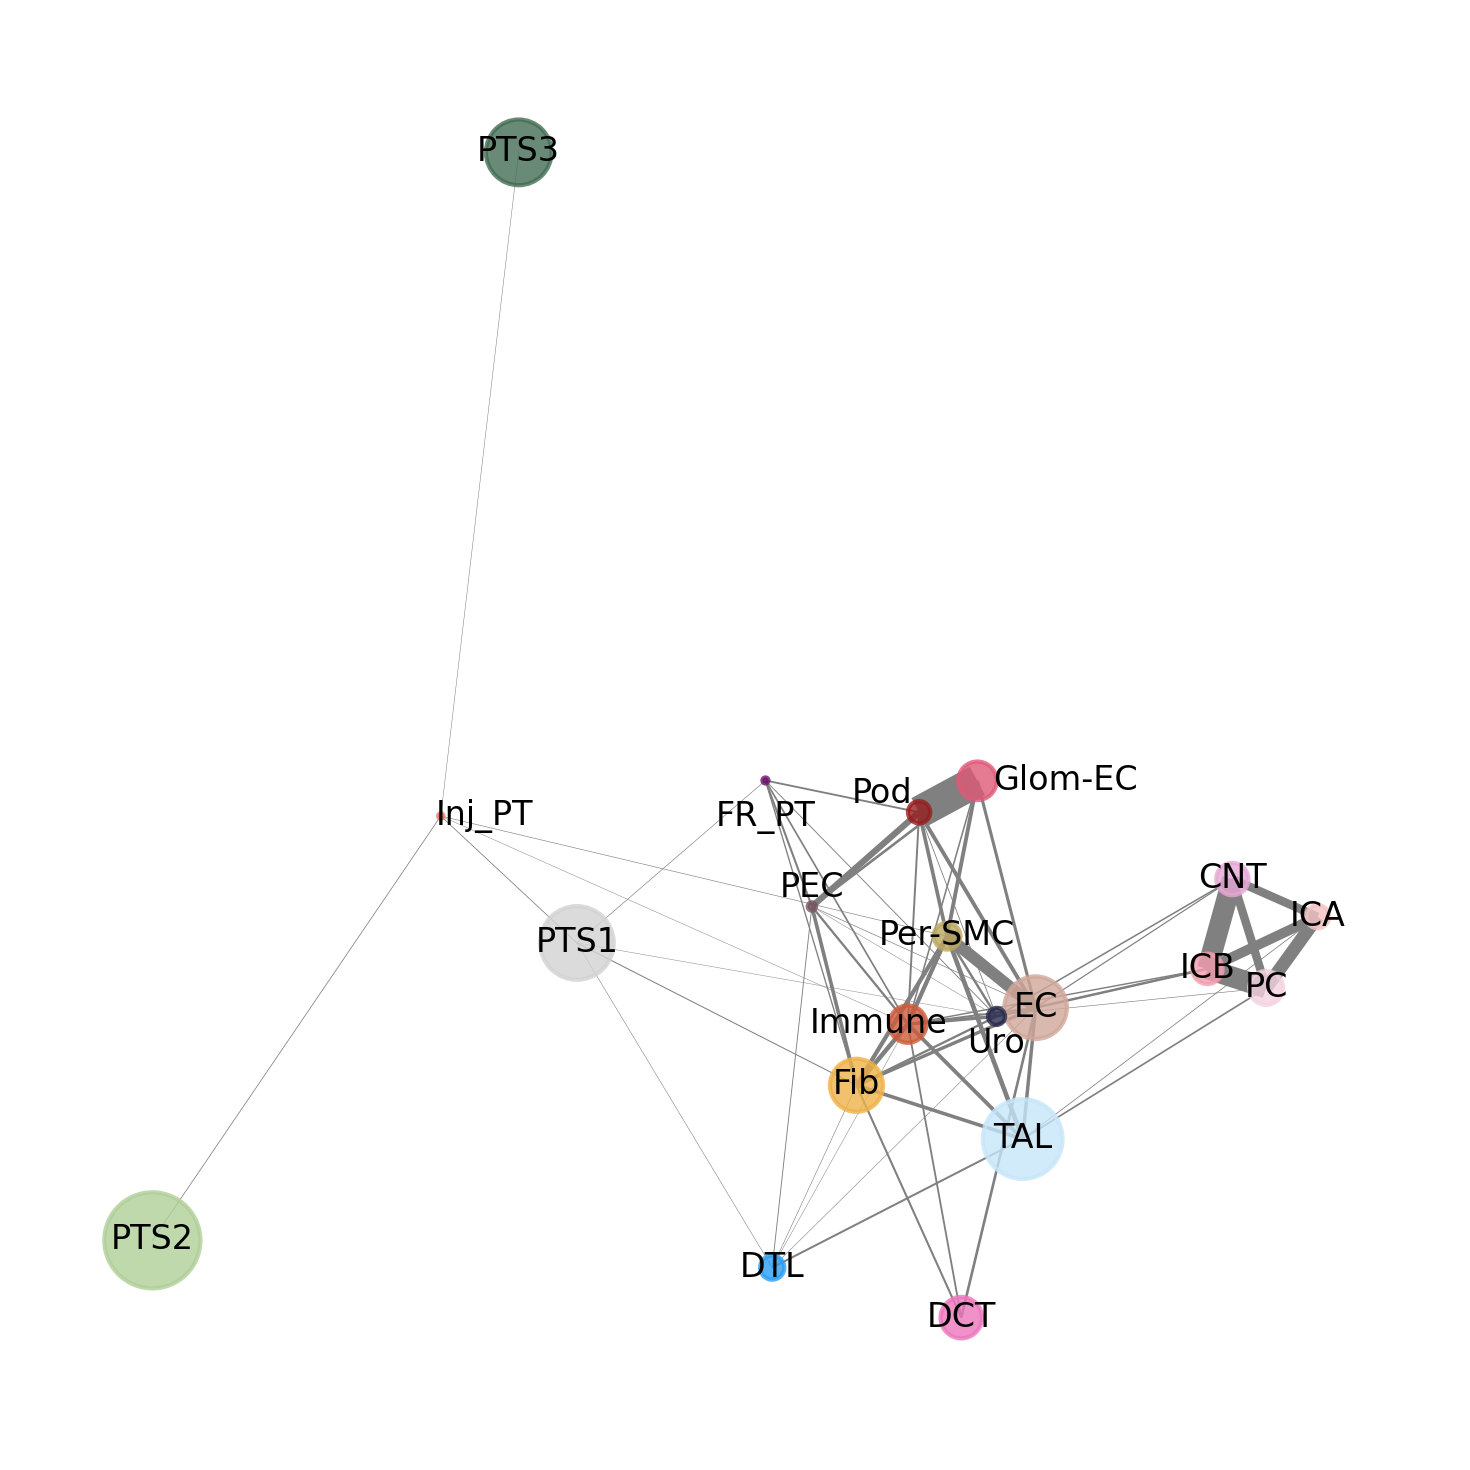

In [358]:
zscore_reset = z_score_df
zscore_reset = zscore_reset.reset_index()
zscore_long = pd.melt(zscore_reset, id_vars=["index"], value_vars=zscore_reset.columns)
zscore_long.columns = ['CellType1', 'CellType2', 'zscore']
zscore_long = zscore_long[zscore_long["CellType1"]!=zscore_long["CellType2"]]
zscore_long = zscore_long.sort_values(by=['CellType1', 'CellType2']).reset_index(drop=True)

G = nx.Graph()

for _,row in zscore_long.iterrows():
    G.add_edge(row['CellType1'], row['CellType2'], weight=row['zscore'])

for _, row in cell_cnt.iterrows():
    G.nodes[row['CellType']]['count'] = row['Count']
    G.nodes[row['CellType']]['color'] = celltype_color_dict.get(row['CellType'])

node_sizes = [G.nodes[node]['count']/node_size_scale_factor for node in G.nodes]
node_colors = [G.nodes[node]['color'] for node in G.nodes]
edge_weights = [G[u][v]['weight'] for u, v in G.edges]
edge_weights = np.array(edge_weights)/edge_weights_scale_factor

pos = nx.spring_layout(G, seed = 6, iterations=10)
label_pos = {k: [v[0], v[1]-0.01] for k, v in pos.items()}  

label_pos["Inj_PT"] = [label_pos["Inj_PT"][0]+0.06, label_pos["Inj_PT"][1]]
label_pos["FR_PT"] = [label_pos["FR_PT"][0], label_pos["FR_PT"][1]-0.04]
label_pos["PEC"] = [label_pos["PEC"][0], label_pos["PEC"][1]+0.02]
label_pos["Pod"] = [label_pos["Pod"][0]-0.05, label_pos["Pod"][1]+0.02]
label_pos["Glom-EC"] = [label_pos["Glom-EC"][0]+0.12, label_pos["Glom-EC"][1]]
label_pos["Per-SMC"] = [label_pos["Per-SMC"][0], label_pos["Per-SMC"][1]]
label_pos["Immune"] = [label_pos["Immune"][0]-0.04, label_pos["Immune"][1]]
label_pos["Uro"] = [label_pos["Uro"][0], label_pos["Uro"][1]-0.03]

fig, ax = plt.subplots(figsize=(5,5),dpi=300)
nx.draw_networkx_edges(G, pos, width = edge_weights, edge_color='#808080')
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha = 0.8)
for node, coordinates in label_pos.items():
    plt.text(coordinates[0], coordinates[1], s=node, fontsize=8, ha='center')
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.tight_layout()
fig.savefig('Colocalization/ShamR_network.pdf', dpi=300, transparent=True, format='pdf', bbox_inches='tight')
plt.show()